In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt


In [34]:
df_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')
df_data.dtypes

id       object
label     int64
dtype: object

In [19]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    df[col_name]=  df[col_name].astype(float)
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

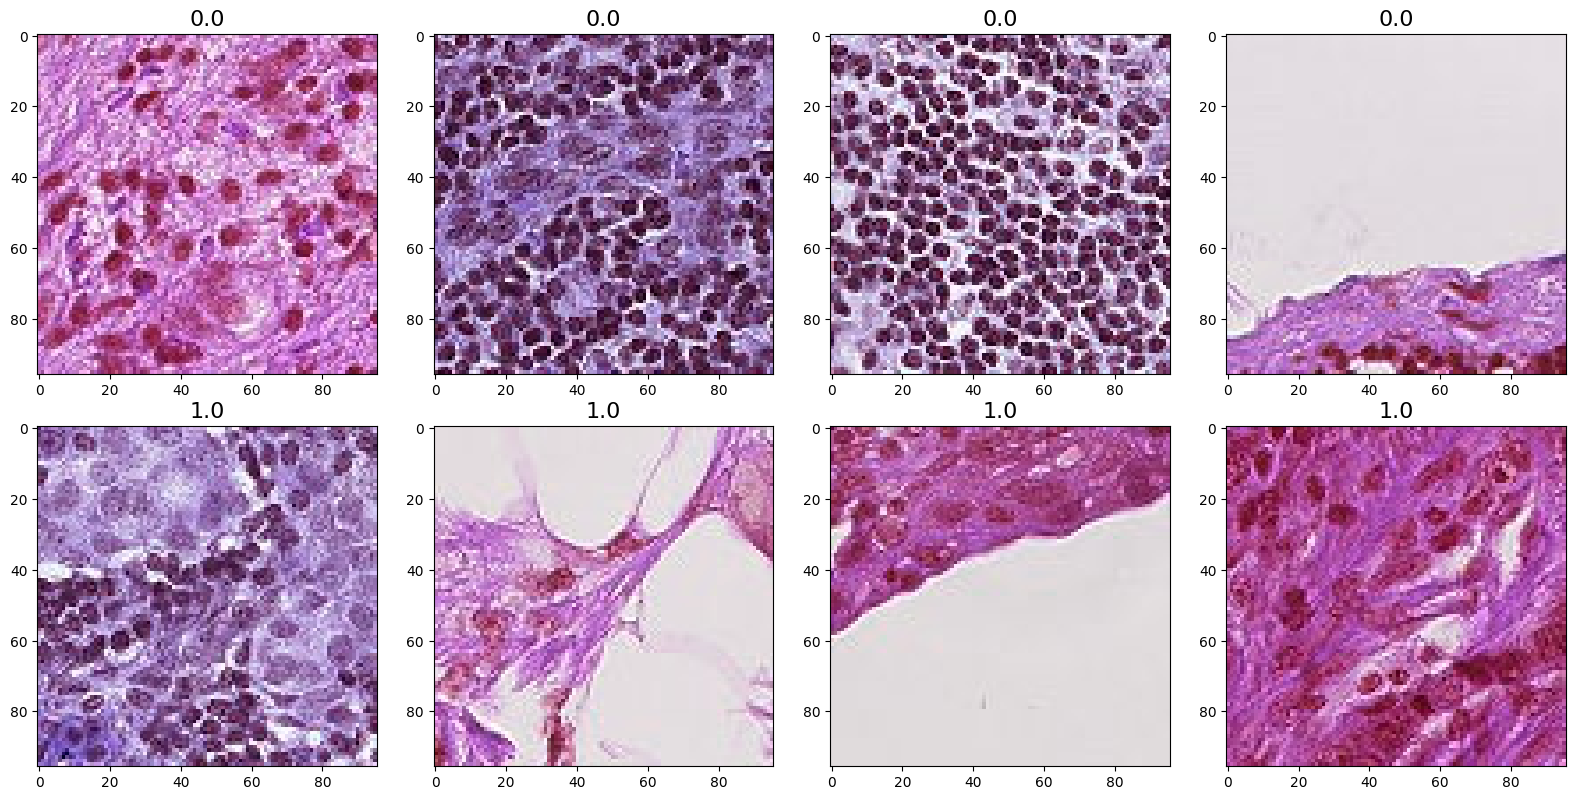

In [26]:
draw_category_images('label',4, df_data,'data/histopathologic-cancer-detection/train/')

In [36]:
from sklearn.model_selection import train_test_split

y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train)
print(df_val)
print(y)

                                              id  label
134709  2ddb582347063e13f6e8e8bcc693c2ddc65f5781      0
122063  9563cbc9f43d2d2ecc1e8b757ee85637db430fe7      0
171972  2ca2f3a7c24ba5c5638089e1c08088ac246454fe      1
63378   ab452f00d0fc2a3dd7c4781c0dcaaecf4d71e4ab      1
36782   85aaec3a61c47e33d4bad167f9c1a013a2ff2401      0
...                                          ...    ...
117398  9e04c5701b81604b04bd340fb86f26c0ec0fa84d      0
87646   86611a3dae286bf57808cce6bd952777a83e2f98      0
99059   7344089a9732d851d3a5d41cf9c7849e53fc1e94      0
121588  a49c538708c85c9be22946c40e284d357bf960b5      0
21829   d7a3e35ffb2dfa20db4aff2c9e91edb64f4a369c      0

[198022 rows x 2 columns]
                                              id  label
79961   0d8c9abf388785a016d72e609ab932b7e134f827      0
45724   5566aa9c1d698535c449144d72e98556bf77fd47      0
81384   358c0ab1962f8f1c202b146d88b35f55252bde9f      1
91989   00f81cefedcc1fb79a5c500677aad14438c50296      0
177529  e7a806a270062

In [45]:
import os
import shutil

base_dir = 'data/histopathologic-cancer-detection/split'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)

df_data_ind = df_data.set_index('id')

train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    
    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    

    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [46]:
from keras.preprocessing.image import ImageDataGenerator

img_size = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

ModuleNotFoundError: No module named 'keras'